# Tracking and Measures on CESM2 LENS Data
## Overview
This tutorial demonstrates how to use Ocetrac for:
* Identifying and tracking spatial-temporal objects in climate data (one ensemble member of CESM2 LENS)
* Calcualtes characteristics of detected objects

In [1]:
import numpy as np
import xarray as xr

import cmocean
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [2]:
import ocetrac

from utils import cesm2_lens_utils
from utils import cesm_anomalies
from measures.shape_measures import ShapeMeasures
from measures.motion_measures import MotionMeasures
from measures.temporal_measures import get_initial_detection_time, get_duration
from measures.intensity_measures import calculate_intensity_metrics
from measures.plotting import plot_displacement
from measures.measures_utils import convert_lon, get_object_masks, run_shape_measures, run_motion_measures, run_temporal_measures, run_intensity_measures, process_objects_and_calculate_measures

# 1. Input specifications and preprocessing

In [3]:
# Define variable name and component
var = 'SST'        # Variable of interest (Sea Surface Temperature)
comp = 'atm'       # Model component (atmosphere)

# Construct directory path using f-string
directory = f'/glade/campaign/cgd/cesm/CESM2-LE/{comp}/proc/tseries/month_1/{var}/'

# Ensemble member index (0 = first member)
ens_memb_index = 0

# Load historical and future datasets using utility function
ds_var_hist_var, ds_var_fut_var = cesm2_lens_utils.get_ds_var(
    directory,
    var,
    comp,
    ens_memb_index)

# Compute variable data (load into memory) and mask land points
var_ds = ds_var_hist_var[var].compute()
# Replace 0s with NaN (land masking)
var_ds_noland = var_ds.where(var_ds != 0, np.nan)

ds_var_hist_var[var]

<xarray.DataArray 'SST' (time: 1980, lat: 192, lon: 288)> Size: 438MB
dask.array<concatenate, shape=(1980, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 16kB 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         K
    long_name:     sea surface temperature
    cell_methods:  time: mean

In [4]:
# Decompose into mean, trend, seasonal cycle, and residuals
# For this example, we will only look at the years 1979 to 2015.
# Looking at the 90th_percentile threshold
mean, trend, seas, features_notrend, var_notrend = cesm_anomalies.calculate_anomalies_trend_features(
    ds=var_ds_noland.sel(time=slice('1979-01','2014-12')),
    threshold_perc=0.9)

# Thresholded anomaly fields
full_mask_land = features_notrend

# Mask out zeros (likely land/ice) by setting them to NaN
full_masked = full_mask_land.where(full_mask_land != 0)

# Binary mask: True = valid ocean data, False = NaN (land/invalid)
binary_out_afterlandmask=np.isfinite(full_masked)
# Secondary mask based on mean field (e.g., climatology or time-mean)
newmask = np.isfinite(mean)

# Force evaluation if using lazy arrays (Dask)
binary_out_afterlandmask = binary_out_afterlandmask.compute()
newmask = newmask.compute()

/glade/u/home/cassiacai/.conda/envs/test_ocetrac/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


# 2. Tracking

In [5]:
obj_Tracker = ocetrac.Tracker(
    binary_out_afterlandmask,
    newmask,
    radius=3, #user-defined parameter
    min_size_quartile= 0.75, #user-defined parameter
    timedim = 'time',
    xdim = 'lon',
    ydim='lat',
    positive=True)

blobs = obj_Tracker.track()
mo = obj_Tracker._morphological_operations()

minimum area: 311.0
initial objects identified 	 5150
final objects tracked 	 386


# 3. Measures

### For this example, we look at one region:

In [6]:
# Defining our region (Pacific Ocean) 
upper_lat = 65
lower_lat = 5
left_lon = 150
right_lon = 250

anomalies_NP = var_notrend.sel(lon=slice(left_lon, right_lon),
                                       lat=slice(lower_lat,upper_lat))
mhw_objs_NP = blobs.sel(lon=slice(left_lon, right_lon),
                                       lat=slice(lower_lat,upper_lat))
print(np.unique(mhw_objs_NP.data)[:-1]) # all ids that have a footprint in the Pacific Ocean bounds

[  4.   8.  11.  16.  18.  24.  27.  28.  35.  38.  59.  62.  63.  71.
  82.  84.  85.  88. 105. 111. 121. 124. 128. 130. 131. 137. 145. 149.
 153. 154. 168. 174. 175. 177. 178. 194. 201. 207. 208. 212. 217. 221.
 225. 226. 227. 231. 232. 235. 240. 253. 254. 258. 259. 260. 262. 267.
 272. 275. 281. 282. 283. 289. 292. 293. 294. 301. 304. 305. 308. 312.
 313. 314. 318. 325. 327. 330. 332. 337. 339. 346. 350. 369. 378. 379.
 381. 382.]


## 3.1 One event

In [63]:
event_binary, event_intensity = get_object_masks(blobs, var_notrend, object_id=226.)

/glade/derecho/scratch/cassiacai/tmp/ipykernel_106795/3397323041.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


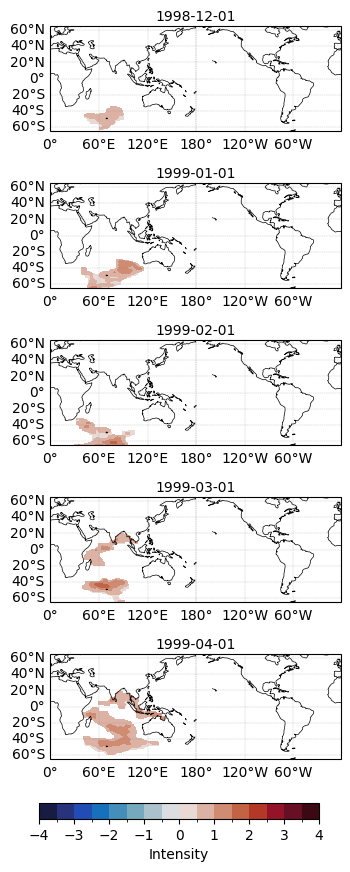

In [64]:
fig, axes = plt.subplots(5, 1, figsize=(4, 8), 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()

for i, ax in enumerate(axes[:11]):  # Only plot first 5
    contour = event_intensity.sel(lat=slice(-65, 65))[i,:,:].plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.balance,
        levels=17,
        vmin=-4,
        vmax=4,
        add_colorbar=False,
        extend='neither'
    )
    
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    time_str = str(event_intensity.time[i].values)[:10]
    ax.set_title(time_str, fontsize=10, pad=4)

cbar_ax = fig.add_axes([0.15, -0.03, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Intensity', fontsize=10)

plt.tight_layout()
plt.show() # This example is actually in the Indian Ocean but looks like at some point, it has a small footprint in the Pacific Ocean (not shown here)

### Shape

In [65]:
# Define spatial resolutions
lon_resolution_value = 111.320  # km per degree longitude
lat_resolution_value = 110.574  # km per degree latitude

# Instantiate the class
metrics = ShapeMeasures(lat_resolution=lat_resolution_value,
                       lon_resolution=lon_resolution_value,
                       use_decorators=False)

# Area-related metrics
spatial_extent_data = metrics.calc_spatial_extents(event_binary)

# Perimeter
perimeters = metrics.calc_perimeter(event_binary)

# Complement to deformation
coords_full = spatial_extent_data['coords_full']
spatial_extents = spatial_extent_data['spatial_extents']
comp_to_deform = metrics.calc_complement_to_deformation(coords_full, spatial_extents)

# Deformation
deform = metrics.calc_deformation(comp_to_deform)

# Convex hull area vs. object area
convex_hull_areas, ratio_convexhullarea_vs_area = metrics.calc_ratio_convexhullarea_vs_area(event_binary)

# Circularity
circularity = metrics.calc_circularity(spatial_extents, perimeters)

In [66]:
print(perimeters)
print(spatial_extents)
print(spatial_extent_data['max_spatial_extent'])
print(spatial_extent_data['mean_spatial_extent'])
print(comp_to_deform)
print(deform)
print(convex_hull_areas)
print(circularity)

[12840.466685413652, 19877.813417377176, 21557.817559868552, 40139.67288988289, 62383.97281866282, 20879.48653034418, 18256.04348638295, 42787.0662891526, 42552.186868265606, 28239.780415804853, 29001.529284735137]
[5566139.569472478, 9954003.884386927, 8429047.029220862, 15338648.677684981, 29880430.636823323, 7619839.288714777, 9934519.26527951, 16395461.811288461, 15681878.02342612, 11373152.14366585, 9559966.063241929]
29880430.636823323
12703007.853927748
[0.28291897 0.25376353 0.15305238 0.27424141 0.13374565 0.37958403
 0.26929119 0.24446706 0.30225025 0.36259685]
[0.71708103 0.74623647 0.84694762 0.72575859 0.86625435 0.62041597
 0.73070881 0.75553294 0.69774975 0.63740315]
[6717623.950409378, 14062736.655204404, 14348913.240474159, 39167391.661781386, 55414750.97351513, 11516622.0136969, 11553863.508841246, 25611463.36680384, 24426431.802653592, 14033875.710066216, 13861783.47039088]
[0.4242309398748281, 0.31657050595140324, 0.227918068861202, 0.11963253525012466, 0.0964829689

### Motion

In [67]:
event_binary_lon = convert_lon(event_binary)
event_binary['lon'] = event_binary_lon['lon_180']
event_intensity['lon'] = event_binary_lon['lon_180']

In [68]:
motion = MotionMeasures(use_decorators=False)

# Calculate centroids
num_centroids = []
centroid_coords = []

for timestep in range(event_binary.time.shape[0]):
    centroids = motion.calculate_centroids(event_binary, timestep)
    num_centroids.append(len(centroids))
    centroid_coords.append(centroids)

print("Number of centroids per timestep:", num_centroids)

# Calculate centroid displacements
centroid_path, centroid_displacements = motion.calculate_centroid_displacement(event_binary)
print("Centroid path:", centroid_path)
print("Displacements (km):", centroid_displacements)

# Calculate centers of mass
num_coms = []
com_coords = []

for timestep in range(event_binary.time.shape[0]):
    coms = motion.calculate_coms(
        event_binary,
        event_intensity, timestep)
    num_coms.append(len(coms))
    com_coords.append(coms)

print("Number of COMs per timestep:", num_coms)

# Calculate COM displacements
com_path, com_displacements = motion.calculate_com_displacement(event_intensity)
print("COM path:", com_path)
print("Displacements (km):", com_displacements)

# Calculate directionality
com_dir = motion.calculate_directionality(com_path)
centroid_dir = motion.calculate_directionality(centroid_path)

print("\nCOM Directionality:")
for k, v in com_dir.items():
    print(f"{k}: {v}")

print("\nCentroid Directionality:")
for k, v in centroid_dir.items():
    print(f"{k}: {v}")

Number of centroids per timestep: [1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1]
Centroid path: [(-48.53403141361257, 68.75), (-48.53403141361257, 77.5), (-54.18848167539267, 62.5), (-25.916230366492147, 70.0), (-24.973821989528798, 85.0), (-3.2984293193717282, 70.0), (-1.4136125654450267, 73.75), (7.0680628272251305, 87.5), (5.183246073298429, 112.5), (-4.240837696335079, 111.25), (-2.3560209424083776, 120.0)]
Displacements (km): [643.9159909517981, 1212.9228472124582, 3203.7696422105755, 1508.9501219600338, 2896.007441149724, 466.35683999533256, 1793.6277553728703, 2771.556364008446, 1057.0683232357997, 993.651900724373]
Number of COMs per timestep: [1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1]
COM path: [(-47.59162303664922, 70.0), (-46.64921465968587, 80.0), (-55.13089005235602, 62.5), (-25.916230366492147, 70.0), (-24.973821989528798, 85.0), (-3.2984293193717282, 70.0), (-1.4136125654450267, 73.75), (8.01047120418848, 87.5), (5.183246073298429, 111.25), (-5.18324607329843, 111.25), (-2.3560209424083776, 1

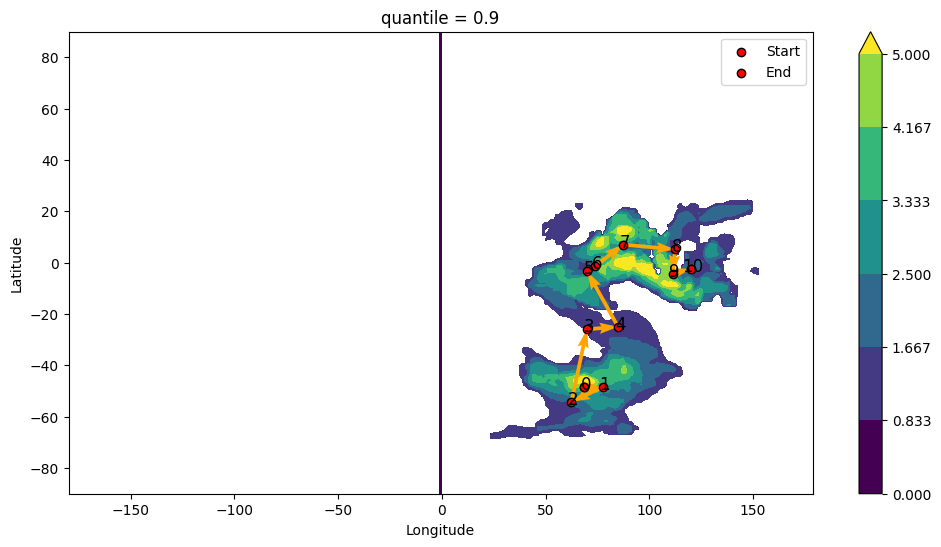

In [70]:
plot_displacement(centroid_path, event_intensity)

### Temporal

In [71]:
initial_detection_date = get_initial_detection_time(
    event_binary,
    units="days since 1850-01-01",
    calendar="noleap")
duration = get_duration(event_binary)

print(initial_detection_date)
print(duration)

1998-12-01 00:00:00
11


### Intensity

In [72]:
intensity_metrics = calculate_intensity_metrics(
    event_intensity)

intensity_metrics = calculate_intensity_metrics(
    event_intensity, quantile_threshold=0.90)

print(f"Maximum intensity: {intensity_metrics['max_intensity']}")
print(f"90th percentile timeseries: {intensity_metrics['percentile_90_intensity_timeseries']}")

Maximum intensity: 2.1457733522070725
90th percentile timeseries: <xarray.DataArray (time: 11)> Size: 88B
array([0.82347254, 1.10577674, 1.08106423, 1.19724209, 1.10096886,
       0.99251082, 1.21014004, 1.12043086, 1.1920588 , 1.48183421,
       1.17666015])
Coordinates:
  * time      (time) object 88B 1998-12-01 00:00:00 ... 1999-10-01 00:00:00
    quantile  float64 8B 0.9


## 3.2 Multiple events and multiple measures

In [73]:
# One event, multiple measures
run_shape = True
run_motion = True
run_temporal = True
run_intensity = True

measure_results = {}

event_binary, event_intensity = get_object_masks(blobs, var_notrend, object_id=226.)

if run_shape:
    measure_results['shape_measures'] = run_shape_measures(
        event_binary, 
        lon_resolution_value, 
        lat_resolution_value)
    print("Shape Measures complete.")

if run_motion:
    measure_results['motion_measures'] = run_motion_measures(
        event_binary, 
        event_intensity)
    print("Motion Measures complete.")

if run_temporal:
    measure_results['temporal_measures'] = run_temporal_measures(
        event_binary)
    print("Temporal Measures complete.")

if run_intensity:
    measure_results['intensity_measures'] = run_intensity_measures(
        event_intensity)
    print("Intensity Measures complete.")

Shape Measures complete.
Motion Measures complete.
Temporal Measures complete.
Intensity Measures complete.


In [74]:
# Multiple events, multiple measures
my_object_ids = [8., 11., 16.] #

run_shape_flag = True
run_motion_flag = False # Example: turn off motion measures
run_temporal_flag = True
run_intensity_flag = True

results_for_my_objects = process_objects_and_calculate_measures(
    my_object_ids,
    blob_data = blobs,
    intensity_data = var_notrend,
    run_shape=run_shape_flag,
    run_motion=run_motion_flag,
    run_temporal=run_temporal_flag,
    run_intensity=run_intensity_flag,
    lon_resolution_value=lon_resolution_value,
    lat_resolution_value=lat_resolution_value
)

Shape Measures complete.
Temporal Measures complete.
Intensity Measures complete.
Shape Measures complete.
Temporal Measures complete.
Intensity Measures complete.
Shape Measures complete.
Temporal Measures complete.
Intensity Measures complete.


In [75]:
results_for_my_objects

{8.0: {'shape_measures': {'perimeters': [9747.292089650471],
   'spatial_extents': [2584050.3227785327],
   'max_spatial_extent': 2584050.3227785327,
   'mean_spatial_extent': 2584050.3227785327,
   'complement_to_deformation': array([], dtype=float64),
   'deformation': array([], dtype=float64),
   'convex_hull_areas': [3513587.4055634644],
   'ratio_convexhullarea_vs_area': [0.7354450094757599],
   'circularity': [0.3417770289684867]},
  'temporal_measures': {'initial_detection_date': cftime.DatetimeNoLeap(1979, 4, 1, 0, 0, 0, 0, has_year_zero=True),
   'duration': 1},
  'intensity_measures': {'max_intensity': 2.8889924833117675,
   'percentile_90_intensity_timeseries': <xarray.DataArray (time: 1)> Size: 8B
   array([2.22573869])
   Coordinates:
     * time      (time) object 8B 1979-04-01 00:00:00
       quantile  float64 8B 0.9}},
 11.0: {'shape_measures': {'perimeters': [12328.482711578845],
   'spatial_extents': [4068020.4550980856],
   'max_spatial_extent': 4068020.4550980856,
 